# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 04 - Encoder-Deconder
---

### <img src="https://img.icons8.com/bubbles/50/null/checklist.png" style="height:50px;display:inline"> Agenda
---
* 自编码器（Auto-encoder） 
    * 潜空间
    * 极大似然估计
    * 隐变量模型
    * 蒙特卡洛采样
    * 变分自编码器
* 序列到序列模型（Seq2Seq）
    * Seq2Seq 模型结构
    * Seq2Seq 的注意力机制
* 自监督学习（Self-Supervised Learning）
    * Masked Autoencoders (Vision Transformers)
    * Bert 
    * GPT
* 对比学习（Contrastive Methods）
    * Contrastive Predictive Coding (CPC)
    * Simple Framework for Contrastive Learning of Visual Representations (SimCLR)
    * Contrastive Language–Image Pre-training（CLIP）

## <img src="https://img.icons8.com/color/96/000000/self-esteem.png" style="height:50px;display:inline"> 自编码器（Auto-encoders）
---
自编码器（Autoencoder）是一种用于无监督学习的神经网络架构，主要用于数据压缩和特征学习。它由两个主要部分组成：编码器（Encoder）和解码器（Decoder）。自编码器在许多领域中都有广泛应用，包括图像处理、自然语言处理和异常检测等。通过有效地学习数据的潜在表示，自编码器为数据分析和理解提供了强大的工具。

下面以图像生成问题为例介绍自编码器：

* 大多数自然数据都是高维的，例如图像。考虑 MNIST（手写数字）数据集，其中每幅图像有 $28x28=784$ 个像素，这意味着它可以用长度为 784 的向量表示。
* 但我们真的需要 784 个值来表示一个数字吗？答案可能是否定的。我们认为数据位于低维空间中，足以描述观察结果。在 MNIST 的情况下，我们可以选择将数字表示为独热向量，这意味着我们只需要 10 个维度。因此，我们可以在低维空间中**编码**高维观察结果。
* 但我们如何才能学习有意义的低维表示？一般的想法是重建或**解码**低维表示为高维表示，并使用重建误差来找到最佳表示（使用误差的梯度）。这是**自动编码器**背后的核心思想。
* **自动编码器** - 将数据作为输入并发现该数据的一些潜在状态表示的模型。输入数据被转换为编码向量，其中每个维度代表有关数据的一些学习属性。这里要掌握的最重要的细节是我们的编码器网络为每个编码维度输出一个值。然后，解码器网络随后获取这些值并尝试重新创建原始输入。自动编码器有**三个部分**：编码器、解码器和将一个部分映射到另一个部分的“损失”函数。对于最简单的自动编码器（即压缩然后从压缩表示中重建原始输入的那种），我们可以将“损失”视为描述重建过程中丢失的信息量。
        *  <center><img src="./assets/tut_xv_autoencoder.png" style="height:250px"></center>
        
* The basic architecture of an autoencoder:
<center><img src="./assets/tut_xiv_autoencoder.png" style="height:250px"></center>
    
    
Let's implement it in PyTorch using what we have learnt so far!

In [1]:
import torch.nn as nn
class AutoEncoder(nn.Module):
    
    def __init__(self, input_dim=28*28, hidden_dim=256, latent_dim=10):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # define the encoder
        self.encoder = nn.Sequential(nn.Linear(self.input_dim, self.hidden_dim),
                                     nn.ReLU(), nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.latent_dim)
                                    )
        
        # define decoder
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim, self.input_dim),
                                     nn.Sigmoid())
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_latent_rep(self, x):
        return self.encoder(x)

In [2]:
import torch
# hyper-parameters:
num_epochs = 5
learning_rate = 0.001

# Device configuration, as before
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# create model, send it to device
model = AutoEncoder(input_dim=28*28, hidden_dim=128, latent_dim=10).to(device)

# Loss and optimizer
criterion = nn.BCELoss()  # binary cross entropy, as pixels are in [0,1], can also use MSE
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 8
num_epochs = 5
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])

fmnist_train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fmnist_train_loader = DataLoader(dataset=fmnist_train_dataset, batch_size=batch_size, shuffle=True)

fmnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
fmnist_test_loader = DataLoader(dataset=fmnist_test_dataset, batch_size=batch_size, shuffle=True)



In [4]:
# Train the model
total_step = len(fmnist_train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(fmnist_train_loader):
        # each i is a batch of 128 samples
        images = images.to(device).view(batch_size, -1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        
        # Backward and optimize - ALWAYS IN THIS ORDER!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/5], Step [100/7500], Loss: 0.3949
Epoch [1/5], Step [200/7500], Loss: 0.3437
Epoch [1/5], Step [300/7500], Loss: 0.3984
Epoch [1/5], Step [400/7500], Loss: 0.3573
Epoch [1/5], Step [500/7500], Loss: 0.3329
Epoch [1/5], Step [600/7500], Loss: 0.3428
Epoch [1/5], Step [700/7500], Loss: 0.3249
Epoch [1/5], Step [800/7500], Loss: 0.4068
Epoch [1/5], Step [900/7500], Loss: 0.3213
Epoch [1/5], Step [1000/7500], Loss: 0.2971
Epoch [1/5], Step [1100/7500], Loss: 0.3132
Epoch [1/5], Step [1200/7500], Loss: 0.3189
Epoch [1/5], Step [1300/7500], Loss: 0.2812
Epoch [1/5], Step [1400/7500], Loss: 0.2755
Epoch [1/5], Step [1500/7500], Loss: 0.3529
Epoch [1/5], Step [1600/7500], Loss: 0.3546
Epoch [1/5], Step [1700/7500], Loss: 0.3404
Epoch [1/5], Step [1800/7500], Loss: 0.2769
Epoch [1/5], Step [1900/7500], Loss: 0.3247
Epoch [1/5], Step [2000/7500], Loss: 0.3327
Epoch [1/5], Step [2100/7500], Loss: 0.2753
Epoch [1/5], Step [2200/7500], Loss: 0.4084
Epoch [1/5], Step [2300/7500], Loss: 0.27

shape: 
 torch.Size([8, 1, 28, 28])


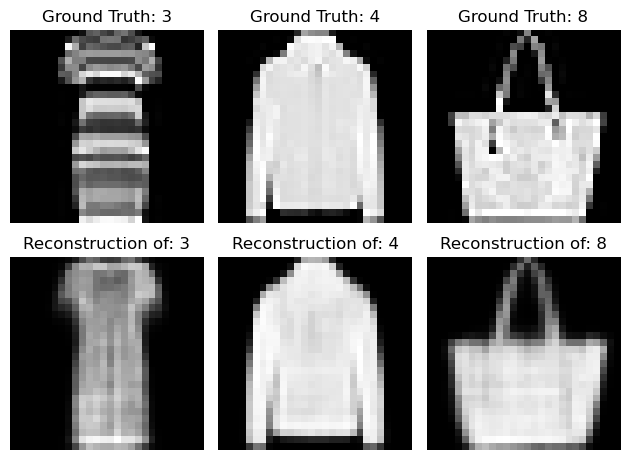

In [5]:
import matplotlib.pyplot as plt
# let's see some of the reconstructions
model.eval()  # put in evaluation mode - no gradients
examples = enumerate(fmnist_test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print("shape: \n", example_data.shape)
fig = plt.figure()
for i in range(3):
    ax = fig.add_subplot(2,3,i+1)
    ax.imshow(example_data[i][0], cmap='gray', interpolation='none')
    ax.set_title("Ground Truth: {}".format(example_targets[i]))
    ax.set_axis_off()
    
    ax = fig.add_subplot(2,3,i+4)
    recon_img = model(example_data[i][0].view(1, -1).to(device)).data.cpu().numpy().reshape(28, 28)
    ax.imshow(recon_img, cmap='gray')
    ax.set_title("Reconstruction of: {}".format(example_targets[i]))
    ax.set_axis_off()
plt.tight_layout()

自编码器用于将高维数据（如图像）压缩到低维的潜在空间，这个潜在空间的表示应捕捉到数据的重要特征。

在这个潜在表示空间上，可以应用不同的降维方法进一步将数据从自编码器的潜在空间降维到可视化的二维空间。

In [6]:
# let's compare different dimensionality reduction methods
n_neighbors = 10
n_components = 2
n_points= 500

fmnist_test_loader = torch.utils.data.DataLoader(dataset=fmnist_test_dataset,
                                          batch_size=n_points, 
                                          shuffle=False)
X, labels = next(iter(fmnist_test_loader))
latent_X = model.get_latent_rep(X.to(device).view(n_points, -1)).data.cpu().numpy()
labels = labels.data.cpu().numpy()

PCA time: 0.0012 sec
KPCA time: 0.011 sec
LLE time: 0.056 sec
Isomap time: 0.1 sec
t-SNE time: 2.7 sec


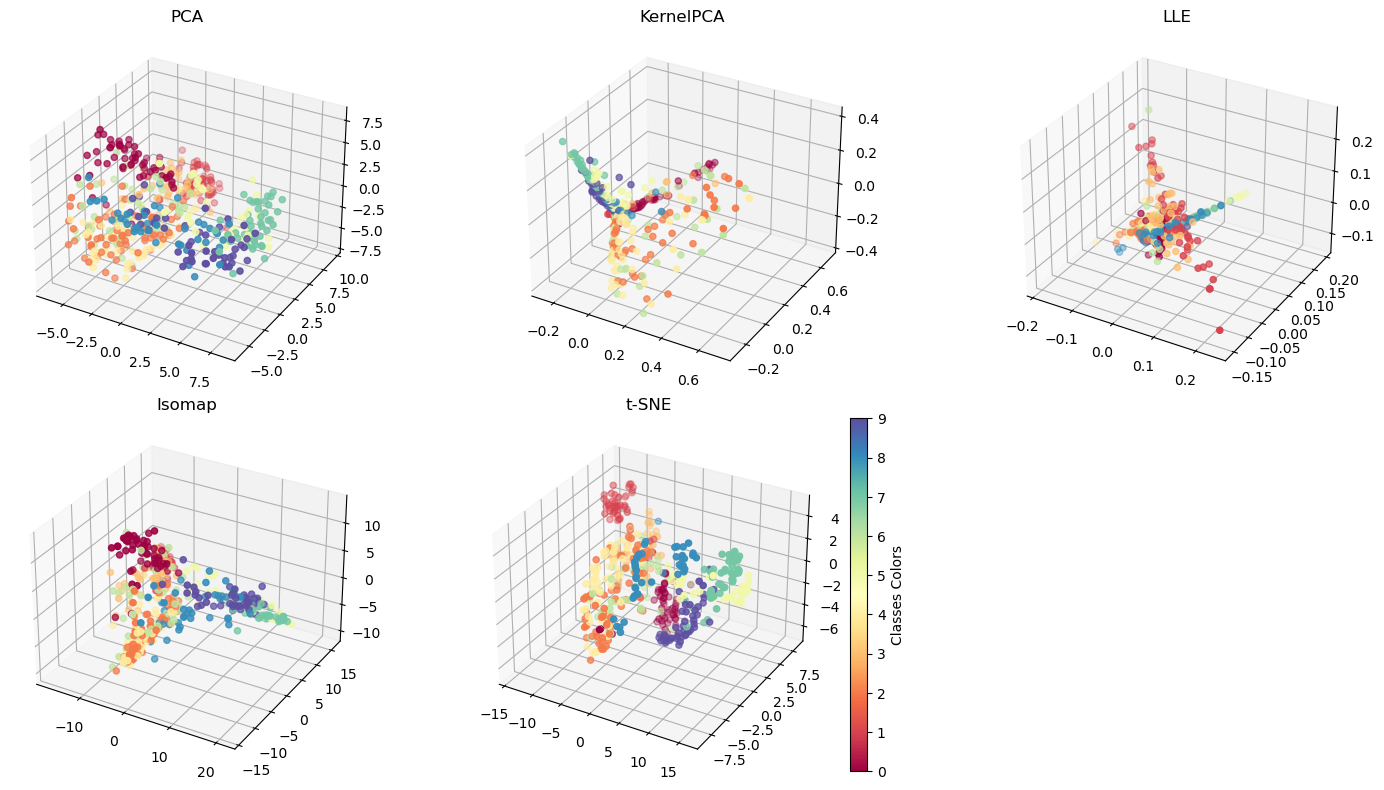

In [7]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import LocallyLinearEmbedding, Isomap, TSNE
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 8))

# PCA
t0 = time.time()
x_pca = PCA(n_components=3).fit_transform(latent_X)
t1 = time.time()
print("PCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 1, projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels, cmap=plt.cm.Spectral)
ax.set_title('PCA')

# KPCA
t0 = time.time()
x_kpca = KernelPCA(n_components=3, kernel='rbf').fit_transform(latent_X)
t1 = time.time()
print("KPCA time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.scatter(x_kpca[:, 0], x_kpca[:, 1], x_kpca[:, 2], c=labels, cmap=plt.cm.Spectral)
ax.set_title('KernelPCA')

# LLE
t0 = time.time()
x_lle = LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=3, eigen_solver='auto').fit_transform(latent_X)
t1 = time.time()
print("LLE time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.scatter(x_lle[:, 0], x_lle[:, 1], x_lle[:, 2], c=labels, cmap=plt.cm.Spectral)
ax.set_title('LLE')

# Isomap
t0 = time.time()
x_isomap = Isomap(n_neighbors=n_neighbors, n_components=3).fit_transform(latent_X)
t1 = time.time()
print("Isomap time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 4, projection='3d')
ax.scatter(x_isomap[:, 0], x_isomap[:, 1], x_isomap[:, 2], c=labels, cmap=plt.cm.Spectral)
ax.set_title('Isomap')

# t-SNE
t0 = time.time()
x_tsne = TSNE(n_components=3).fit_transform(latent_X)
t1 = time.time()
print("t-SNE time: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 3, 5, projection='3d')
scatter = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], x_tsne[:, 2], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE')

bounds = np.linspace(0, 10, 11)
cb = fig.colorbar(scatter, ax=ax, spacing='proportional', ticks=bounds)
cb.set_label('Classes Colors')

plt.tight_layout()
plt.show()


### <img src="https://img.icons8.com/?size=100&id=18519&format=png&color=000000" style="height:50px;display:inline"> 潜空间（latent space）
---

在深度学习中，编码器通常是一个神经网络，它通过学习将高维输入数据（如图像、音频或文本）转换为潜空间中的低维向量表示。这个低维向量表示捕捉了输入数据的重要特征和结构，其中每个维度可能对应着数据的某个抽象特征。

潜空间具有一些有用的属性。

* 首先，潜空间具有较低的维度，因此可以更有效地表示数据，并且可以减少冗余信息。
* 其次，潜空间的向量可以进行数学运算，例如向量加减法，这种运算在潜空间中对应着对输入数据的语义操作，例如在图像中添加或去除特定特征。这使得潜空间成为生成模型和重构模型的重要组成部分。

潜空间在许多机器学习任务中都发挥着重要作用，包括图像生成、图像重构、特征提取和数据压缩等。通过学习潜空间的结构和特征，可以实现更高级别的数据分析和操作。

一个好的潜空间应该具备以下几个特点：


1. **有意义的表示**：潜空间中的每个维度应该对应着输入数据的某个有意义的特征。这意味着相似的数据在潜空间中应该更接近，而不相关的数据应该更远离。例如，在图像领域，潜空间的某个维度可以表示图像中的颜色，另一个维度可以表示形状。这种有意义的表示使得在潜空间中的运算和操作更加直观和可解释。


2. **低维度**：潜空间的维度应该相对较低，以便有效地表示数据并减少冗余信息。通过将高维数据映射到低维空间，可以提取数据中最重要的特征，并且可以更高效地进行计算和操作。


3. **连续性**：潜空间中的向量应该具有连续性，即在潜空间中相邻的向量应该对应着在输入空间中相似的数据。这种连续性使得在潜空间中进行插值或插入新的向量时，能够产生合理和平滑的结果。例如，在图像生成任务中，通过在潜空间中对两个不同的向量进行线性插值，可以生成一个介于它们之间的新图像。


4. **可操作性**：潜空间中的向量应该具有可操作性，即可以通过对向量进行数学运算来实现对输入数据的语义操作。例如，在图像生成任务中，可以通过在潜空间中对某个向量的特定维度进行增减操作，来改变生成图像中的某个特征，如颜色、形状等。


5. **一致性**：潜空间应该在不同的输入数据之间保持一致，即相同类型的数据在潜空间中应该有相似的表示。这样可以确保潜空间的泛化能力，使得相似的数据具有相似的表示，而不同类别的数据有明显的区分。


一个好的潜空间设计可以使得在该空间中的数据表示更加有效、有意义，并且可以支持各种任务，包括生成、重构、插值和语义操作等。潜空间和图像生成模型之间有密切的关系，潜空间是图像生成模型的关键组成部分之一。

* 生成模型旨在从潜空间中生成逼真的图像。这些模型通常使用生成对抗网络，扩散模型或变分自编码器等方法。

* 以图象生成为例，在这些模型中，一个重要的步骤是将输入映射到潜空间中的向量表示，这个过程通常由编码器完成。

* 编码器将输入图像转换为潜空间中的向量表示，其中每个向量维度对应着图像的某个特征。这个向量可以被看作是图像的隐含表示或特征向量。此特征向量可以被用于进行各种图像操作，例如生成新的图像、重构原始图像或者在潜空间中进行插值操作。

* 生成模型的另一部分是解码器，它的任务是将潜空间中的向量转换回图像空间。解码器接收潜空间中的向量，并将其解码为逼真的图像。这个过程可以被视为对潜空间向量的逆映射。

* 通过训练生成模型，可以学习到一个优化的潜空间表示，其中潜空间中的向量可以被解码成高质量的图像。从而可以在潜空间中进行图像操作，例如通过在潜空间中调整特定维度的值来改变图像的特征，或者通过在潜空间中进行插值来生成介于两个向量之间的新图像。


### <img src="https://img.icons8.com/?size=100&id=32601&format=png&color=000000" style="height:50px;display:inline"> 极大似然估计（Maximum Likelihood Estimation，MLE）
---

生成模型的本质是极大似然估计。我们希望通过有限的样本来估计总体的潜在表示，即数据的真实分布 $p(x)$。假设样本数据 $p(x)$ 服从某种分布。对于连续数据，常用的分布是高斯分布 $\mathcal{N}\left(\mu, \sigma^2\right)$。这里，$p(x)$ 代表了我们希望通过模型去近似和生成的真实数据的分布。

一旦假设了 $p(x)$ 的分布形式，概率分布估计问题就转化为了参数估计问题。联合概率分布 $p(x; \theta)$ 可以表示为：
$$
L(\theta ; X)=P(X ; \theta)=\prod_{i=1}^n p\left(x_i ; \theta\right)
$$

其中，$\theta$ 可以看作是模型的训练参数，上述表达式也被称为似然函数。最大化似然函数等同于最小化负对数似然函数。取对数是为了将连乘符号变为连加符号，方便计算，公式如下：
$$
\hat{\theta}=\arg \max _\theta L(\theta ; X)=\arg \min _\theta-\sum_{i=1}^n \log p\left(x_i ; \theta\right)
$$

在优化的过程中需要求解关于参数 $\theta$ 的梯度:
$$
\nabla_\theta L(\theta ; X)=-\nabla_\theta \sum_{i=1}^n \log p\left(x_i ; \theta\right)=-\sum_{i=1}^n \nabla_\theta \log p\left(x_i ; \theta\right)
$$

按照梯度下降的方法, 极大似然估计就可以求出参数 $\theta$, 得到概率分布, 最后采样生成图片。

极大似然估计存在的一个关键的问题：**该方法是有假设存在的，假设了 p(x) 服从某种分布**。如果假设分布与数据的真实分布不一致，MLE的效果可能会受到影响。

更重要的是，**分布的选择是需要领域知识或先验的**，需要对生成过程很了解，否则如果选择的分布和真实分布不一致，那么结果可能很差。现实世界中的问题往往非常复杂，通常难以完全了解其生成过程，也难以找到能准确描述该过程的概率分布形式。因此，假设的分布可能与真实分布存在差异，甚至完全错误。

如果实在没办法确定假定分布，实际上也可以通过不同的模型来拟合$f$。根据具体的应用场景和数据的特点，我们可以选择以下几种常见的模型来描述 $P(x ; \theta)$。
- 线性模型
- 神经网络
- 混合模型
- 等等...

即便使用模型尝试进行拟合，在没有好的归纳偏置情况下，效果依然差强人意。下面，引出隐变量模型：

### <img src="https://img.icons8.com/?size=100&id=bxK5SpQHsVmH&format=png&color=000000" style="height:50px;display:inline"> 隐变量模型（Hidden variables model）
---

隐变量可以作为解决图片生成这一困难问题的跳板，这个思路在数学中非常常见，例如：我们想直接根据变量“a”，求解结果“b”非常困难，而由“a”求解“c”和由“c”求解“b”都很简单，那么可以选择绕开最难的部分，而选择“a →c →b”的求解方法。

在图像生成为例：如果根据图片样本直接求解数据分布 $p(x)$ 很难，那么可以通过隐变量实现，例如考虑手写体数字例子，一般在写数字的时候会首先想到要写哪个数字，同时脑子里想象它的样子，然后才是写下来形成图像。

这个过程可以总结成两个阶段：

1. 先决定数字及其它影响因素，用隐变量 $z$ 来表示；
2. 再根据隐变量 $z$ 生成数字图像。这就是隐变量模型，用数学描述为：
$$
P(X)=\int P(X \mid z ; \theta) P(z) \mathrm{d} z
$$

通常假定 $z$ 服从正态分布 $z \sim \mathcal{N}(0, I), P(X \mid z ; \theta)$ 可以换成 $f(z ; \theta)$, 即用一个参数为 $\theta$ 的函数去计算样本 $X$ 的概率分布 $P(X \mid z ; \theta)$ 。这里采用条件分布形式是因为它可以显式的表明 $X$ 依赖 $z$ 生成。
$$
P(X)=\int f(z ; \theta) P(z) \mathrm{d} z
$$

隐变量模型背后的关键思想是: **任何一个概率分布经过一个足够复杂的函数后可以映射到任意概率分布**。

如示例中, $z$ 服从标准高斯分布, 来样后经过函数 $f(z ; \theta)$ 的变换后可以变成手写体数字的真实分布 $P(X)$ 。

通过隐变量模型, **极大似然估计的问题已经被绕过去了**，不再需要指定复杂的概率分布形式也不怕出现分布不一致的情况。只需要求解函数 $f(z ; \theta)$ 即可(也就是求解模型)

这个函数看似很难求解, 实际上就是很难求解, 不过我们有神经网络这一利器，**深度学习最有魅力的一点就是拟合能力, 但凡直接求解很困难的问题, 都可以交给神经网络进行拟合。**

下面采用一些优化算法进行求解即可，例如梯度下降，牛顿法等等

关于 $\theta$ 的梯度为:
$$
\nabla_\theta L(\theta ; X)=-\sum_{i=1}^n \frac{\int \nabla_\theta p\left(x_i \mid z ; \theta\right) p(z) \mathrm{d} z}{\int p\left(x_i \mid z ; \theta\right) p(z) \mathrm{d} z}
$$

根据上述的梯度公式就可以优化参数, 得到最后的隐变量模型。

但隐变量模型存在问题: 计算 $\nabla_\theta L(\theta ; X)$ 的过程中需要计算分子和分母的积分, 为了使得 $z$ 能表达更多的信息，通常假设 $z$ 是一个连续的随机变量。在这种情况下, **一般无法直接求解准确值，会存在计算困难的问题**。



### <img src="https://img.icons8.com/?size=100&id=PJel6Hfekiea&format=png&color=000000" style="height:50px;display:inline"> 蒙特卡洛采样（Monte Carlo Sampling）
---
**蒙特卡洛采样的基本步骤如下**

隐变量模型在计算梯度时存在积分难计算的问题。针对求积分问题，很难计算准确值，因此通常采用蒙特卡罗采样去近似求解

原来的积分可以写成期望的形式 $\int p(x \mid z ; \theta) p(z) \mathrm{d} z=\mathbb{E}_{z \sim p(z)}[p(x \mid z ; \theta)]$, 然后利用期望法求积分, 步骤如下。

(1) 从 $p(z)$ 中多次采样 $z_1, z_2, \cdots, z_m$ ；

(2) 根据 $p(x \mid z ; \theta)$ 计算 $x_1, x_2, \cdots, x_m$

(3) 求 $x$ 的均值。用数学表达为:

$$
\int p(x \mid z ; \theta) p(z) \mathrm{d} z=\mathbb{E}_{z \sim p(z)}[p(x \mid z ; \theta)] \approx \frac{1}{m} \sum_{j=1}^m p\left(x_j \mid z_j ; \theta\right)
$$

通过对 $z$ 多次采样，可以计算 $\nabla_\theta L(\theta ; X)$ 的近似值。

**简单来说, 蒙特卡洛采样就是通过样本的均值来近似总体的积分。**

蒙特卡罗采样存在的问题是：采样次数一般需要很大。主要是由两个因素引起的：

（1）**高维度**：对于高维问题，由于“维度的诅咒”，可能需要指数级的采样数才能在所有维度上获得足够的覆盖。这是因为在高维空间中，大部分的体积都在靠近边界的区域，所以需要大量的样本才能精确地估计整个空间的性质。

（2）**稀疏区域**：如果感兴趣的分布在某些区域中非常稀疏，那么大多数的蒙特卡罗样本可能都会落入不关心的区域，而真正关心的区域可能会被严重地欠采样。这会导致估计结果严重偏离真实值。

解决这两个问题的方法可以缩小 $z$ 的取值空间。缩小 $p(z)$ 的方差 $\sigma^2$, 那么 $z$ 的采样范围会缩小, 采样的次数 $m$ 也不需要那么大。同时, 也可能把生成坏样本的 $z$ 排除, 生成更像真实样本的图像。这其实就引出了下面要介绍的变分自编码器 VAE 的原理。

### <img src="https://img.icons8.com/?size=100&id=KKRe9LOjJRZ8&format=png&color=000000" style="height:50px;display:inline"> 变分自编码器（Variational Autoencoder）
---

**继续上一节的问题, 怎么能缩小 $z$ 的取值空间呢?**

* 原来 $z$ 从先验概率分布 $p(z)$ 中采样,现在可以考虑从 $z$ 的后验概率分布 $p(z \mid X)$ 中采样。
* 具体来说, 给定一个真实样本 $X$, 假设存在一个专属于 $X$ 的分布 $p(z \mid X)$ (后验分布)，并进一步假设这个分布是独立的、多元的正态分布。

**如何理解后验概率 $p(z \mid X)$ 会比先验概率 $p(z)$ 更好呢?** 

* 这是因为后验概率包含了更多的信息。先验概率只反映了在没有观察数据之前对隐变量的知识或者假设，它通常被设置为一种简单的分布，如高斯分布或者均匀分布。而后验概率则是在观察到数据之后，对隐变量的最新认识，它包含了数据的信息。

* 例如，假设我们的任务是对人脸图片进行建模，隐变量可能代表一些人脸的特性，如性别、年龄等。在没有看到任何图片的情况下，可能假设所有的性别和年龄都是等可能的，这就是先验概率。但是当看到一些图片之后，可能会发现实际上某些性别或者年龄的人脸图片更常见，这就是后验概率。

* 因此，当我们说后验概率比先验概率更好，其实是说，后验概率包含了更多的来自于数据的信息，能够更准确地反映真实世界的情况。在变分自编码器中，编码器的目标就是学习表示后验概率分布。

**从数学角度出友, 如何求出后验概率分布 $p(z \mid X)$ 呢?**

* 求隐变量的后验分布是变分推断的一个核心问题。

* 一般是无法准确求出后验分布的, 但是变分推断可以用另一个分布 $q_\theta(z \mid X)$ 近似估计 $p(z \mid X)$, 然后从 $q_\theta(z \mid X)$ 中采样来近似从 $p(z \mid X)$ 中采样。
* 这种方法是用一个函数近似另一个函数，其实就是用神经网络来近似概率分布参数。

在变分推断的背景下, 我们有一个复杂的概率分布, 通常是后验概率分布 $p(z \mid X)$, 这里 $z$ 是隐变量, $X$ 是观察到的数据。目标是找到一个相对简单的分布 (比如高斯分布), 称其为 $q_\theta(z \mid X)$, 用它来近似真实的后验分布。其中， $\theta$ 表示分布的参数, 需要找到合适的 $\theta$ 来最大化这种近似的准确性。

**那么, 如何度量这种 “近似”的准确性呢?**

* 这就需要用到 KL 散度, 它是一种衡量两个概率分布之间 “距离” 的方法。
* 目标就是找到参数 $\theta$, 使得 $q_\theta(z \mid X)$ 和 $p(z \mid X)$ 之间的 KL散度最小。
* 然后, 这个最小化问题可以通过梯度下降等优化算法来求解

**变分推断就是一种用优化的方式来逼近复杂的概率分布的方法**。通过在函数空间中进行梯度下降，找到一个可以用来近似真实分布的简单分布。但是，还有一个很大的问题：**$p(z \mid X)$ 是未知的**, 所以无法直接计算 $\mathrm{KL}$ 散度。

解决这个问题的方法是通过引入一个叫做**证据下界(Evidence Lower Bound, ELBO)** 的量。ELBO 是模型对数似然的一个下界, 它与 KL 散度的和是一个常数, 这个常数就是观测数据的对数似然。因此, 最大化 ELBO 等价于最小化 KL 散度，其解释详见概率统计教程。

ELBO 可以写成以下形式:
$$
\mathrm{ELBO}=E_{q_\theta(z \mid X)}[\log p(X \mid z)]-K L\left(q_\theta(z \mid X) \| p(z)\right)
$$

* 第一项 $E_{q_\theta(z \mid X)}[\log p(X \mid z)]$ 是重构误差, 代表了生成的数据与实际数据的相似程度, 具体来说, $X \sim q_\theta(z \mid X)$ 表示有一个 $X$ 可以根据分布 $q_\theta(z \mid X)$ 采样一个 $z$, 这个过程可以理解为把 $X$ 编码成 $z$, 此过程被称为 VAE 模型的编码器。 $p(X \mid z)$ 表示根据 $z$ 生成输出结果,此过程被称为 VAE 模型的解码器。整体表示给定 $x$ 编码成 $z$ 再重构得到输出结果, 这个过程的期望, 被称为重构误差。如果这个期望很大, 表明得到的 $z$ 是 $X$ 的一个好的表示, 能够抽取 $X$ 足够多的信息来重构输出结果, 让它与 $X$ 尽可能相似。

* 第二项 $\mathrm{KL}\left(q_\theta(z \mid X) \| p(z)\right)$ 是 $q_\theta(z \mid X)$ 和先验分布 $p(z)$ 的 KL 散度, 代表了隐变量的分布偏离先验分布的程度。

* 可以看到, 计算 ELBO 并不需要知道后验分布 $p(z \mid X)$ 的具体形式, 只需要知道数据的生成模型 $p(X \mid z)$和隐变量的先验分布 $p(z)$, 而这两者通常都是可以设定的, 所以可以计算。因此, 可以通过最大化 ELBO 来实现变分推断。

实际上，**ELBO就等价于VAE的损失函数**，VAE的训练目标就是最大化ELBO（证据下界）。负ELBO由两部分组成：

* 第一部分是期望的重构误差，它衡量的是模型生成的数据与真实数据的匹配程度；
* 第二部分是KL散度，它衡量的是隐变量的分布偏离先验分布的程度。

重构误差可以用各种不同的方式来计算，例如使用均方误差或者交叉熵损失。至于KL散度，由于通常假设先验分布是标准正态分布，所以KL散度可以用隐变量的均值和方差来显式计算。

VAE的损失函数公式表示如下：

$$
\operatorname{loss}_{\mathrm{VAE}}(\phi, \theta)=-\sum_{i=1}^n E_{\boldsymbol{z}_i \sim q_\phi\left(\boldsymbol{z}_i \mid \boldsymbol{x}_i\right)}\left[\log p_\theta\left(\boldsymbol{x}_i \mid \boldsymbol{z}_i\right)\right]-K L\left(q_\phi\left(\boldsymbol{z}_i \mid \boldsymbol{x}_i\right) \| p\left(\boldsymbol{z}_i\right)\right)
$$

**Tip：大家有时候可能会看到有人将VAE的损失函数中的KL散度项表示为：**
$$
\frac{1}{2} \sum_{i=1}^l\left(\exp \left(\sigma_i\right)-\left(1+\sigma_i\right)+\left(\mu_i\right)^2\right)
$$

这是可以进行推导的在变分自编码器中, 通常会假设隐变量$z$的先验分布是标准正态分布, 即 $p(z)=\mathcal{N}(0, I)$ 。还会假设编码器给出的后验分布也是一个高斯分布, 即 $q_\theta(z \mid X)=\mathcal{N}\left(\mu, \sigma^2 I\right)$,其中 $\mu$ 和 $\sigma$ 是由神经网络给出的。在这种情况下, $q_\theta(z \mid X)$ 和 $p(z)$ 之间的 KL 散度可以显式计算出来：

首先, 两个高斯分布之间的 KL散度的公式为:
$$
K L\left(\mathcal{N}\left(\mu_1, \sigma_1^2\right) \| \mathcal{N}\left(\mu_2, \sigma_2^2\right)\right)=\frac{\left(\mu_1-\mu_2\right)^2+\sigma_1^2-\sigma_2^2+2\left(\log \sigma_2-\log \sigma_1\right)}{2 \sigma_2^2}
$$

在 VAE 中, 设定先验分布 $p(z)=\mathcal{N}(0,1)$, 即 $\mu_2=0, \sigma_2^2=1$, 而后验分布 $q_\theta(z \mid X)=\mathcal{N}\left(\mu, \sigma^2\right)$, 即 $\mu_1=\mu, \sigma_1^2=\sigma^2$, 将这些代入，可以得到:

这就是 KL 散度的公式。但是, 由于通常使用 $\log \sigma^2$ (记作 $\sigma$ ) 作为神经网络的输出 (为了确保 $\sigma^2$ 的非负性），可以对公式再做一些变换:
$$
\mathrm{KL}\left(q_\theta(z \mid X) \| p(z)\right)=\frac{\mu^2+\mathrm{e}^\sigma-1-\sigma}{2}
$$

这就是 VAE 论文中所给出的 KL 散度项的公式。如果有 $l$ 个隐变量, 那么整个 KL 散度项就是所有维度上的 $\mathrm{KL}$ 散度之和, 公式如下:
$$
\sum_{i=1}^l\left(\frac{1}{2}\left(\mu_i^2+\exp \left(\sigma_i\right)-1-\sigma_i\right)\right)
$$

这就是在 VAE 损失函数中需要最小化的 KL 散度项的公式。

### <img src="https://img.icons8.com/?size=100&id=KKRe9LOjJRZ8&format=png&color=94D82D" style="height:50px;display:inline"> VAE的简明指导
---

从模型角度来说，VAE 架构就是在原本的 AE 结构上, 为编码添加合适的噪声。其原因朴素的自编码在训练过程中很容易出现**过拟合现象**，如下所示：

<center><img src="./assets/ae1.png" style="height:300px"></center>

假设用一些全月图和一些半月图去训练一个AE，经过训练，模型能够很好地还原出这两张图片，如图5-2所示。接下来在潜空间中取两张图片编码点中任意一点，将这点交给解码器进行解码，直觉上会得到一张介于全月图和半月图之间的图片（如阴影面积覆盖3/4）。然而，实际上，这个点经过解码器解码后的结果不仅模糊而且还是乱码的，这就是自编码的过拟合现象。

**为什么会出现这种现象？**

一个直观上的解释是AE的Encoder和Decoder都使用了神经网络，神经网络是一个非线性的变换过程，因此在潜空间中点与点之间关系往往没有规律可循。解决此问题的一种方法是引入噪声，使得图片的编码区域得到扩大，从而掩盖掉失真的空白编码点。

<center><img src="./assets/ae2.png" style="height:300px"></center>

在对两张图片进行编码时引入一定的噪声，使得每个图片的编码点出现在潜空间的矩形阴影范围内，如上图所示。

* 在训练模型时，矩形阴影范围内的点都有可能被采样到，这样解码器在训练过程中会尽可能地将矩形阴影内的点还原为与原图相似的图片。接着，对之前提到的失真点，此时它位于全月图和半月图编码的交界处。

* 因此，解码器希望失真点既能尽量与全月图相似，又能尽量与半月图相似，因此它的还原结果将是两种图的折中（例如3/4的全月图）。通过这个例子发现给编码器增加一些噪声，可以有效覆盖失真区域。

* 然而，引入区域噪声的方法还不够充分，因为噪声的范围总是有限的，不可能覆盖所有采样点。

* 为了解决此问题，可以尝试将噪声的范围无限延伸，以使得对于每个样本，其编码能够覆盖整个编码空间。但是需要确保，在原始编码附近的编码点具有最高的概率，随着离原始编码点的距离增加，编码的概率逐渐减小。

* 在这种情况下，图像的编码将从原来离散的编码点变成一个连续的编码分布曲线，如图

<center><img src="./assets/ae3.png" style="height:300px"></center>

这种将图像编码由离散变为连续的方法，就是变分自编码的核心思想。其结构如下图：

<center><img src="./assets/ae4.png" style="height:300px"></center>

首先将 input 输入到编码器, 计算出两组编码: 

* 一组编码为均值编码 $m=\left(m_1, m_2, m_3\right)$, 
* 另一组为控制噪声干扰程度的方差编码 $\sigma=\left(\sigma_1, \sigma_2, \sigma_3\right)$, 这两组参数分别通过两个神经网络计算得到。
* 其中方差编码 $\sigma$ 主要用来为噪音编码 $z=\left(e_1, e_2, e_3\right)$ 分配权重, 在分配权重之前对方差编码 $\sigma$ 进行了指数运算，主要是因为神经网络学习出来的权重值是有正负值的，加入指数运算保证分配到的权重是正值。
* 最后，将原编码 $m$ 和经过权重分配后噪声编码进行叠加，得到新的隐变量，再送入解码器。
* 损失函数这一项除了之前传统AE的重构损失以外, 还多了一项损失: $\sum_{i=1}^3\left(\exp \left(\sigma_i\right)-\left(1+\sigma_i\right)+\left(m_i\right)^2\right)$ 。这一项的推导在之前也已经证明过。

实际上，也可以运用**反证法**的思想来推敲这个新损失的意义。

* 当不引入这个损失函数时，模型会努力减少生成图片的重构误差来提高图片质量。
* 为了实现这一点，编码器会期望减少噪音对生成图片的影响，降低任务难度。因此，它会倾向于给噪音分配较低的权重。如果没有任何约束限制，网络只需要将方差编码设置为接近负无穷大的值，从而消除噪音的影响。
* 即$(\exp \left(\sigma_i\right) e_i=0)$, 此时 $(m_i)$ 就等于它本身, 模型就退化成了普通的自编码器，过拟合问题就会卷土重来。尽管此时模型的训练效果可能非常好，但生成的图片往往会非常糟糕。

为了方便理解，可以做一个生活中的类比。将变分自编码器（VAE）的工作过程类比为参加高考的过程。在学生们准备高考的过程中，他们需要进行大量的模拟考试以提高最终的考试成绩，这就像VAE在训练阶段所做的事情。 模拟考试的题目和难度由老师安排，这能够公正地评估学生们的学习能力。类似地，VAE的训练过程中，它生成的数据的分布，即方差编码 σ，

应由某个损失函数（可以理解为“老师”）来决定。如果没有老师的监督，让学生们自己设置模拟考试的难度，他们很可能将试题设得非常简单，以便得高分。这就像VAE在没有适当的损失函数约束时，可能倾向于降低噪声的影响，让模型重构误差尽可能地接近于零。 因此，为了保证VAE在实际应用中的表现，而不是通过降低噪声影响来“投机取巧”，需要引入一个适当的损失函数。这个损失函数就像老师一样，监督VAE的训练过程，确保模型在适当的难度下进行训练，从而能够在复杂的真实世界任务中表现得更好。

所以，除了重构误差，VAE还让所有的**矩阵 c 都向标准正态分布看齐**，这样就防止了 $(\exp \left(\sigma_i\right) e_i=0)$，进而造成噪声为零的情况，保证VAE模型不会退化成自编码器，如下图


<center><img src="./assets/ae5.png" style="height:500px"></center>

### <img src="https://img.icons8.com/?size=100&id=48130&format=png&color=000000" style="height:50px;display:inline"> Seq2Seq Models
---

Seq2Seq模型可以被认为是一种Encoder-Decoder模型的变体，其特别适用于处理序列到序列的任务，编码器将输入序列映射为一个固定长度的向量表示，解码器则使用这个向量表示来生成输出序列。它已被广泛应用于机器翻译、对话系统、语音识别等自然语言处理任务。Seq2Seq模型的结果框架如图

<center><img src="./assets/seq2seq1.png" style="height:300px"></center>

以机器翻译任务为例来讲解图1的Seq2Seq结构。假设现在的模型输入是文本序列“hello world”，想得到输出结果为“你好，世界”。在Seq2Seq模型中，**编码器负责将输入序列映射到一个特征向量 c**，希望通过训练可以让该向量提取到输入信息的语义特征，将来送入解码器中作为解码器的一部分输入信息。编码器通常采用循环神经网络或卷积神经网络来处理输入序列。

解码器负责生成输出序列，它通常也采用循环神经网络或其它变体来处理输出序列。与编码器类似，解码器也由多个时间步组成。在每个时间步，解码器使用前一个时间步的输出元素和当前时间步的隐藏状态来生成当前时间步的输出元素。具体来说，在解码器的初始时刻, 通常会将编码器输出的特征向量 $c$ 和起始向量 $<b o s>$ 拼接到一起,作为初始时刻的隐藏状态 $s_0$, 并计算得到当前时刻的输出信息 $y_1$ 。在下一时刻 $t_1$, 会将编码器输出的特征向量 $\boldsymbol{c}$ 和 $y_1$ 拼接成一个向量作为当前时刻 $t_1$ 的输入, 并计算得到当前时刻的输出 $y_2$ 以此类推下去, 直到模型预测出结束向量 $\langle e o s\rangle$ 时停止。不难发现, 解码器的输入信息不仅包含了当前要翻译的单词，还包含了当前这句话的上下文语义信息; 解码器会结合这两部分信息预测当前的输出，这就是解码器翻译文本为什么有效。

### Seq2Seq的attention机制


#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 考虑在解码器翻译每一个单词时都用这同一个特征向量 c 作为输入是否合适？
---

**对注意力分数进行建模**

假设输入序列是 $x_1, x_2, \cdots, x_n$, 对应的编码器隐藏状态为 $h_1, h_2, \cdots, h_n$ 。解码器的当前隐藏状态为 $s_t$。首先计算解码器隐藏状态 $s_t$ 与所有编码器隐藏状态 $h_i$ 之间的相似性分数 $e_{t, i}$ 。可以通过点积、加权点积或其他相似性度量来计算:
$$
e_{t, i}=\operatorname{score}\left(s_t, h_i\right)
$$

$s_t$ 和某些 $h_i$ 越相似，意味着这些编码器隐藏状态的语义信息 $h_i$ 就是在翻译文本 $x_t$ 时应该着重关注的地方。 

接下来, 将这些分数转换为权重, 通过 softmax 函数进行归一化:
$$
\alpha_{t, i}=\frac{\exp \left(e_{t, i}\right)}{\sum_{j=1}^n \exp \left(e_{t, i}\right)}
$$

其中 $\alpha_{t, i}$ 可以看作是解码器在时间步 $t$ 时关注编码器隐藏状态 $h_i$ 的权重。接着计算加权和的上下文向量 $c_t$, 公式如下:
$$
c_t=\sum_{i=1}^n \alpha_{t, i} h_i
$$

上下文向量 $c_t$ 捕获了输入序列与解码器当前时间步的相关性。然后, 将上下文向量 $c_t$ 与解码器的隐藏状态 $s_t$ 结合起来，以生成下一个输出单词的概率分布, 公式如下:
$$
y_t=\operatorname{softmax}\left(W\left(s_t, c_t\right)+b\right)
$$

其中 $\mathrm{W}$ 和 $\mathrm{b}$ 是需要学习的权重和偏置项。通过这种方式，注意力机制帮助Seq2Seq模型关注输入序列的重要部分，从而提高了预测性能。

### <img src="https://img.icons8.com/cute-clipart/64/000000/task.png" style="height:50px;display:inline"> 自监督学习方法与模型（Self-Supervised Learning）
---
* 一种无监督学习的版本，其中**数据提供监督**。
* **核心想法**：保留部分数据，然后让神经网络根据剩余部分进行预测。

* 优于监督学习的地方：
1. 为每个任务生成新数据集的成本很高（准备标签手册、类别、雇用人员、创建 GUI、存储管道等）。
2. 良好的监督可能并不便宜（例如，医学、法律）。
3. 利用互联网上大量未标记的数据（图像、视频、语言）。

<center><img src="./assets/ss_learning.PNG" style="height:300px"></center>

* 从过去的数据预测未来的数据。这在时间序列预测（如股价预测、天气预报）中非常常见。
* 从最近的过去预测即将发生的事件。这种方法在短期预测中尤为有效。
* 从当前的数据预测过去的数据。这在数据修复和缺失数据填充中有应用。
* 在空间序列数据中，从下部数据预测上部数据。例如，在图像数据中，可以从图像的下半部分预测上半部分。
* 从可见的部分预测被遮挡的部分。例如，在图像处理中，从未被遮挡的部分预测被遮挡的部分。


---
**下面介绍一些经典的使用自监督的模型。**


### <img src="https://img.icons8.com/external-wanicon-lineal-color-wanicon/64/null/external-mask-brazilian-carnival-wanicon-lineal-color-wanicon.png" style="height:50px;display:inline">  Masked Autoencoders (Vision Transformers)
---
* 虽然自监督领域已经随着对比方法的引入而风靡一时，但 Vision Transformers (ViT) 的最新发展重新唤起了蒙版图像建模的简单想法。
* <a href="https://arxiv.org/abs/2111.06377">Masked Autoencoders Are Scalable Vision Learners, He et al. 2021.</a>
* **Masked Autoencoders**：在预训练期间，**大量随机图像块子集**（例如 75%）被蒙版。编码器应用于可见块的小子集。在编码器之后引入蒙版标记，全套编码块和蒙版标记由小型解码器处理，该解码器以像素为单位重建原始图像。预训练后，解码器被丢弃，编码器应用于未损坏的图像（全套块）以执行识别任务。
* 掩蔽 AE 表现出与对比方法相当的性能，同时更易于实现和理解。
* Code:
    * HuggingFace: <a href="https://huggingface.co/docs/transformers/model_doc/vit_mae">ViTMAE</a>
    * GitHub: <a href="https://github.com/facebookresearch/mae">Official PyTorch implementation (FAIR)</a>, <a href="https://github.com/EdisonLeeeee/Awesome-Masked-Autoencoders">Awesome MAE Models</a>

<center><img src="./assets/masked_ae.PNG" style="height:300px"></center>

<center><img src="./assets/masked_ae_sample.PNG" style="height:220px"></center>

<center><img src="./assets/masked_ae_table.PNG" style="height:150px"></center>

### <img src="https://img.icons8.com/?size=100&id=pVCJSBDTZxYl&format=png&color=000000" style="height:50px;display:inline">  Bert And GPT
---

在自监督学习背景下，BERT (Bidirectional Encoder Representations from Transformers) 和 GPT (Generative Pre-trained Transformer) 是自然语言处理领域非常经典的工作：

**BERT的训练方式**

* BERT的训练目标是Masked Language Modeling (MLM) 和 Next Sentence Prediction (NSP):

* Masked Language Modeling (MLM):

在输入句子中随机选择一些单词，将它们替换为一个特殊的标记（如[MASK]）。

模型的任务是基于上下文预测被掩盖的单词。例如，对于句子 "The cat sat on the [MASK]", 模型需要预测[MASK]处的单词 "mat"。

这种方法让模型在预训练阶段学会利用左右上下文信息，从而获得双向表示。

* Next Sentence Prediction (NSP):

给定两个句子A和B，模型需要预测B是否为A的下一个句子。

训练数据由50%的正样本（即B是真正的下一个句子）和50%的负样本（即B是从语料库中随机选择的句子）组成。

这一任务帮助模型学习句子级别的关系和上下文连接。

**GPT的训练方式**

* GPT的训练目标是Causal Language Modeling (CLM):
 
使用标准的自回归语言模型，即给定前面所有的单词，预测下一个单词。

例如，对于句子 "The cat sat on the", 模型需要预测下一个单词 "mat"。

模型只利用前向上下文（即左侧的单词），不会利用右侧的上下文信息。这种训练方式被称为单向或自回归训练。


尽管BERT和GPT的训练方式有所不同，它们都属于自监督学习的范畴，**因为它们利用未标注的大规模语料库，通过设计合适的预测任务来自主生成训练数据**。这种方式不仅减少了对人工标注数据的依赖，而且能有效地从大量无标注文本中学习语言表示。

<center><img src="./assets/bertgpt.png" style="height:400px"></center>

[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)

[(GPT-1): Improving Language Understanding by Generative Pre-Training](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)

[(GPT-2): Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

[(GPT-3): Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)

### <img src="https://img.icons8.com/plasticine/100/000000/protect-from-magnetic-field.png" style="height:50px;display:inline">  对比学习（Contrastive Learning）
---
对比学习（Contrastive Learning）是自监督学习（Self-Supervised Learning）的一种子类。自监督学习是通过设计合适的预测任务，从未标注的数据中生成训练信号来进行学习的一种方法。**而对比学习通过构建正负样本对，来学习数据表示的相似性和差异性**。

* 对比学习是一种为 ML 模型制定**寻找相似和不相似事物的任务的方法**。
* 顾名思义，对比方法通过对比**正例和负例**来学习表示。
* 使用这种方法，可以训练机器学习模型对相似和不相似的图像进行分类。
* 更正式地说，对于任何数据点 $x$，对比方法旨在学习编码器 $f$，使得：

$$score(f(x), f(x^+)) >> score(f(x), f(x^-))$$

* 上式被称为**得分函数** 是衡量两个特征相似度的指标。
* $x^+$ 是与 $x$ 相似的数据点，称为 *正例* 样本。
* $x^−$ 是与 $x$ 不相似的数据点，称为 *负例* 样本。

<center><img src="./assets/contrastive_1.PNG" style="height:150px"></center>
<center><img src="./assets/contrastive_puzzle.gif" style="height:200px"></center>

* <a href="https://analyticsindiamag.com/contrastive-learning-self-supervised-ml">Image Source</a>

* 最常见损失函数是**InfoNCE**损失，它看起来与softmax类似。

<center><img src="./assets/infonce_loss.png" style="height:100px"></center>

- $\mathcal{L}_N$: InfoNCE损失函数
- $\mathbb{E}_X$: 对所有样本$x$的期望
- $f(x)$: 输入样本$x$通过神经网络得到的表示（embedding）
- $f(x^+)$: 输入样本$x$的正样本（positive sample）的表示（embedding），即与$x$相似或相关的样本
- $f(x_j)$: 输入样本$x$的负样本（negative samples）的表示（embedding），即与$x$不相似或无关的样本，其中$j$为负样本的索引
- $N$: 样本对的总数，包括1个正样本和$N-1$个负样本

* 分子部分表示样本$x$与其正样本$x^+$的表示向量的点积的指数。点积越大，指数值越大，表示$x$与$x^+$的相似度越高。
* 分母部分包括了样本$x$与正样本$x^+$的相似度指数，以及样本$x$与所有负样本$x_j$的相似度指数的和。目的是将正样本与负样本进行对比。
* <a href="https://github.com/RElbers/info-nce-pytorch">InfoNCE Loss in PyTorch</a>

### <img src="https://img.icons8.com/pastel-glyph/64/000000/qr-code--v2.png" style="height:50px;display:inline">  Contrastive Predictive Coding (CPC)
---
* <a href="https://arxiv.org/abs/1807.03748">**对比预测编码 (CPC)**</a> 通过使用强大的自回归模型在学习到的 *潜在空间* 中**预测未来**，从而学习自监督表示。
* 该模型使用概率对比损失，从而诱导潜在空间捕获**对预测未来样本最有用**的信息。

<center><img src="./assets/cpc.png" style="height:300px"></center>

图示展示了CPC的架构，通过一个序列示例（如音频信号）进行解释。尽管图中使用的是音频输入，实际上同样的设置可以用于图像、文本和强化学习等。

1. 输入序列：

图示底部的波形表示一个音频输入序列，输入序列为${x_{t-3}, x_{t-2}, x_{t-1}, x_t, x_{t+1}, x_{t+2}, x_{t+3}, x_{t+4}}$。

2. 编码器（$g_{enc}$）：

每个输入$x_t$通过编码器$g_{enc}$转化为潜在表示$z_t$。编码器将高维输入数据压缩到低维的潜在空间。

3. 自回归模型（$g_{ar}$）：

自回归模型$g_{ar}$对过去的潜在表示进行建模，生成上下文表示$c_t$。上下文表示$c_t$总结了当前时间步之前的所有信息，用于预测未来。自回归模型（$g_{ar}$）通常是循环神经网络（RNN，Recurrent Neural Network），如长短期记忆网络（LSTM，Long Short-Term Memory）或门控循环单元（GRU，Gated Recurrent Unit）。这些模型可以有效地捕捉时间序列数据中的依赖关系。

4. 预测未来：

使用上下文表示$c_t$预测未来的潜在表示$z_{t+k}$。图示中展示了对未来多个时间步的预测。这个预测网络通常是一个多层感知器（MLP, Multi-Layer Perceptron），但也可以使用其他模型结构，例如卷积神经网络（CNN）或递归神经网络（RNN）。

5. 对比损失：

CPC通过对比损失函数来进行训练，该损失函数使得正确的未来预测在表示空间中更接近，而不相关的预测更远离。具体来说，正例可以是未来时间步 $t+1$ 和 $t+2$ 的表示，即 $f\left(x_4\right)$ 和 $f\left(x_5\right)$ 。反例可以是与当前时间步无关的其他时间步的表示，如 $f\left(x_1\right), f\left(x_2\right)$ 或者从其他序列中随机选取的表示。

* <a href="https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch">PyTorch 代码</a>

**训练后的应用**
训练得到的这些模型组件可以用于以下几个方面：

**特征提取：**

编码器：可以用作特征提取器，将输入数据映射到潜在空间。这些潜在表示可以作为输入特征用于其他机器学习模型，如分类器、回归器等。例如，在图像分类任务中，可以将图像通过编码器生成特征表示，然后用这些特征进行分类。

**下游任务：**

编码器和自回归模型：可以用于时间序列预测、生成任务以及异常检测。例如，在金融时间序列预测中，可以使用编码器生成的特征表示和自回归模型生成的上下文表示进行未来价格预测。

编码器和预测模型：可以用于生成模型和增强学习任务，例如在自然语言处理任务中，可以生成下一句或下一段文本。

### <img src="https://img.icons8.com/nolan/64/collapse-arrow.png" style="height:50px;display:inline">  Simple Framework for Contrastive Learning of Visual Representations (SimCLR)
---
* <a href="https://arxiv.org/abs/2002.05709">**Simple Framework for Contrastive Learning of Visual Representations (SimCLR)**</a> is a framework for contrastive learning of *visual* representations. 
* It learns representations by maximizing agreement between differently augmented views of the same data example via a contrastive loss in the latent space.

<center><img src="./assets/simclr.png" style="height:300px"></center>

1. 数据增强:
- 对原始图像 $x$ 进行两次不同的随机数据增强，生成两个增强视图 $\tilde{x}_i$ 和 $\tilde{x}_j$ 。
- 增强操作由增强函数集合 $\mathcal{T}$ 生成。
2. 编码器:
- 经过增强后的图像 $\tilde{x}_i$ 和 $\tilde{x}_j$ 分别通过编码器 $f(\cdot)$ 生成表示 $h_i$ 和 $h_j$ 。
3. 投影头:
- 表示 $h_i$ 和 $h_j$ 进一步通过投影头 $g(\cdot)$ 生成潜在空间中的表示 $z_i$ 和 $z_j$ 。
4. 对比学习:
- 通过对比损失（如InfoNCE）最大化 $z_i$ 和 $z_j$ 之间的一致性，最小化 $z_i$ 与其他样本表示之间的相似度。
- 损失函数的目标是使相同数据示例的增强视图在潜在空间中的表示更接近，而不同数据示例的表示则更远离。

<center><img src="./assets/simclr_anim.gif" style="height:350px"></center>
 

* <a href="https://github.com/sthalles/SimCLR">PyTorch Code</a>
* <a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture7_selfsupervised_demos.ipynb#scrollTo=YB_cqJagEXbw">Colab Example</a>

### <img src="https://img.icons8.com/external-gradients-pongsakorn-tan/64/null/external-clip-gdpr-gradients-pongsakorn-tan.png" style="height:50px;display:inline">  CLIP - Contrastive Language–Image Pre-training
---
CLIP是一种由OpenAI开发的神经网络模型，旨在通过自然语言监督高效地学习视觉概念。CLIP能够在没有专门训练的情况下，理解并分类图像中的内容。

CLIP的工作过程可以分为三个主要步骤：

**1. 对比预训练（Contrastive Pre-training）**
* 数据收集：CLIP使用来自互联网的大规模数据集，这些数据集包含了图像和与之配对的文本描述。例如，一张狗的照片可能会配有“这是一只狗”的文字说明。
* 图像编码器和文本编码器：在预训练阶段，CLIP会同时训练一个图像编码器和一个文本编码器。图像编码器将图像转换为一组特征向量，文本编码器将文本转换为另一组特征向量。
* 对比学习：通过对比学习，CLIP会学习到哪些图像和文本是正确配对的。简单来说，模型会尽量使正确配对的图像和文本的特征向量相似度更高，而错误配对的相似度更低。

**2. 从标签文本创建数据集分类器（Create Dataset Classifier from Label Text）**
* 文本描述转化：在完成预训练之后，CLIP可以将各种类别的名称（标签）转化为自然语言描述。例如，将“狗”这个标签转化为“狗的照片”。
* 文本编码：这些自然语言描述通过文本编码器转换为特征向量，这些向量与图像编码器输出的图像特征向量进行对比。

**3. 用于零样本预测（Use for Zero-shot Prediction）**
* 零样本分类：在推理阶段（即实际应用中），CLIP可以进行零样本分类。这意味着，即使模型没有见过特定的图像类别，只要给定一个文本描述（例如“猫的照片”），模型就可以预测图像是否符合该描述。
* 配对预测：CLIP会为每张图像计算与所有文本描述的相似度，选择相似度最高的文本描述作为预测结果。例如，对于一张新的动物照片，CLIP可以判断它更像是“狗的照片”还是“猫的照片”。

* <a href="https://github.com/openai/CLIP">Official Repository (PyTorch)</a>
* <a href="https://colab.research.google.com/github/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb">Colab Example - Interaction with CLIP and Zero-Shot Classification</a>
* HuggingFace Demos:
    * <a href="https://huggingface.co/openai/clip-vit-large-patch14">CLIP-ViT-Large</a>
    * <a href="https://huggingface.co/spaces/taesiri/CLIPScore">CLIPScore</a>

<center><img src="./assets/openai_clip.PNG" style="height:600px"></center>

<center><img src="./assets/clip_zero_shot.PNG" style="height:250px"></center>

#### CLIP Extensions
---
* <a href="https://github.com/yzhuoning/Awesome-CLIP">Awesome-CLIP</a> - a repository that collects CLIP-based applications
* <a href="https://arxiv.org/abs/2107.07651">ALBEF - Align Before Fuse</a>
    * <a href="https://github.com/salesforce/ALBEF/">PyTorch Code</a>
* <a href="https://arxiv.org/abs/2204.05991">ReCLIP - A Strong Zero-Shot Baseline for Referring Expression Comprehension</a>
    * <a href="https://github.com/allenai/reclip">PyTorch Code</a>
* <a href="https://arxiv.org/abs/2303.15343">SigLIP - Sigmoid Loss for Language Image Pre-Training</a>
    * <a href="https://huggingface.co/docs/transformers/main/en/model_doc/siglip">Model on HF</a>
* <a href="https://github.com/mlfoundations/open_clip">OpenCLIP - an open source implementation of CLIP</a>

## <img src="https://img.icons8.com/stickers/100/null/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://ruder.io/transfer-learning/">Sebastian Ruder - Transfer Learning - Machine Learning's Next Frontier</a>
* <a href="https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html">Jacob Devlin and Ming-Wei Chang - Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing</a>
* <a href="https://sites.google.com/view/berkeley-cs294-158-sp20/home">CS294-158-SP20-Deep Unsupervised Learning</a>
* <a href="https://paperswithcode.com/method/contrastive-predictive-coding">Contrastive Predictive Coding</a>
* <a href="https://paperswithcode.com/method/simclr"> Simple Framework for Contrastive Learning of Visual Representations (SimCLR)</a>
* <a href="https://leimao.github.io/blog/Exponential-Moving-Average/">Exponential Moving Average</a>
* <a href="https://paperswithcode.com/method/moco">Momentum Contrast</a>
* <a href="https://untitled-ai.github.io/understanding-self-supervised-contrastive-learning.html">Understanding self-supervised and contrastive learning with "Bootstrap Your Own Latent" (BYOL)</a>
* <a href="https://creatis-myriad.github.io/2022/06/01/EmergingPropertiesSSViT.html">MYRIAD - Emerging Properties in Self-Supervised Vision Transformers</a>
* <a href="https://openai.com/blog/clip/">OpenAI - CLIP: Connecting Text and Images</a>